In [1]:
import shapefile
import zipfile
import shapely
import pyproj
import pandas as pd
from shapely.geometry import LineString
import osmnx as ox
import geopandas as gpd
from numpy.linalg import norm
import numpy as np
import math
from matplotlib import pyplot as plt
import contextily as cx
from pyproj.crs import CRS
import scipy

from shapely.ops import linemerge

import route2vel
import route2vel.utils as utils
from route2vel.loading import load_graph
from route2vel.route import find_route
import route2vel
from notebookutils import *

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
plt.style.use('dark_background')

Interpolate a single polyline obtained from a route, while trying to identify route parts.

In [4]:
graph_area = "Città Metropolitana di Bologna"

In [5]:
route2vel.load_config("../..")

In [6]:
graph = load_graph(graph_area)
graph_gdf_nodes, graph_gdf_edges = ox.graph_to_gdfs(graph)

Loading graph from D:\Documenti\Universita\tesim\resources\graph\Città Metropolitana di Bologna.graphnx.pickle ...
Loaded in 1.06s!


In [7]:
# use two routes to make a complex route in shape, use simple pathfinding to increase
# complexity as it would tend to go on straighter roads otherwise
route1 = find_route(graph, "Ospedale Maggiore, Bologna", "Porta Santo Stefano, Bologna", weight='length')
route2 = find_route(graph, "Porta Santo Stefano, Bologna", "Bologna Fiere, Bologna", weight='length')
route_gdf: gpd.GeoDataFrame = ox.utils_graph.route_to_gdf(graph, route1[:-1] + route2, 'travel_time') # use recently added osmnx function instead of ours

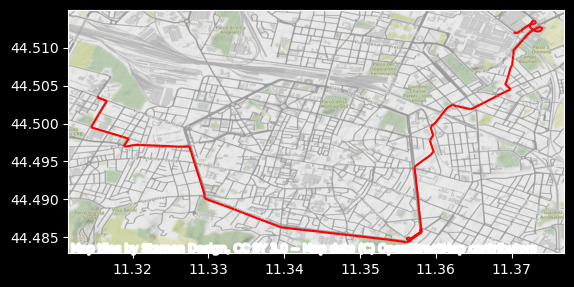

In [8]:
fig, ax = plt.subplots()
route_gdf.plot(ax=ax, color='red')
cx.add_basemap(ax=ax, crs=route_gdf.crs)
plt.show()

LINESTRING (11.315534 44.5036091, 11.315505 44.5035721, 11.3154525 44.5035006, 11.3153997 44.5034286, 11.3154604 44.5034063, 11.315524 44.503383, 11.3156146 44.5033498, 11.3158816 44.5032519, 11.3163217 44.5030906, 11.316622 44.5029805, 11.3165678 44.5028915, 11.3160905 44.5021088, 11.3160663 44.5020692, 11.3156814 44.5014408, 11.3156261 44.5013478, 11.3150682 44.5003928, 11.3150528 44.500367, 11.3150412 44.5003475, 11.3149809 44.50025, 11.3146203 44.4996614, 11.3145246 44.4995053, 11.3153324 44.4992606, 11.3154319 44.4992305, 11.315646 44.4991656, 11.3167508 44.4988309, 11.3169209 44.4987794, 11.3170362 44.4987461, 11.3180033 44.4984598, 11.3186544 44.4982589, 11.3186902 44.4982472, 11.3187962 44.4982141, 11.3189221 44.4981736, 11.3194383 44.4980128, 11.3194989 44.4979939, 11.3194654 44.4979434, 11.3192007 44.4975432, 11.318933 44.4971513, 11.3189032 44.4971082, 11.3188532 44.4970087, 11.3189444 44.4969901, 11.3190756 44.496978, 11.3191954 44.4969767, 11.319333 44.4969905, 11.3195914 

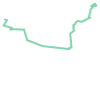

In [9]:
def remove_adjacent_duplicates(lst):
    i = 1
    while i < len(lst):
        if lst[i] == lst[i - 1]:
            del lst[i]
        else:
            i += 1
    return lst

ptlist = [pt for x in route_gdf['geometry'] for pt in x.coords]
remove_adjacent_duplicates(ptlist)
merged_route_polyline: shapely.LineString = shapely.LineString(ptlist)
print(merged_route_polyline)
merged_route_polyline

In [10]:
from typing import Callable
from shapely import Point

def coord_distance_meters(coords1:tuple, coords2:tuple, lon_first=True):
    """Convert coord distance to meters. Make sure to use WGS-84 coordinates.
    """
    if lon_first:
        coords1 = coords1[::-1]
        coords2 = coords2[::-1]

    return ox.distance.great_circle_vec(*coords1, *coords2)

def split_linestring_by_curves(linestring: LineString, distance_treshold: float, 
                                distance_func: Callable[[tuple, tuple, bool], float] = coord_distance_meters,
                                lon_first=True,
                                add_borders_as_new_group_first=True,
                                return_labels=True,
                                return_geoseries=False,
                                ) -> "list[dict|(LineString|Point)]":
    result = []
    labels = []
    current_group = [linestring.coords[0]]
    group_under_treshold = None
    for prev_point, current_point in zip(linestring.coords[:-1], linestring.coords[1:]):
        distance = distance_func(prev_point, current_point, lon_first)
        
        cur_under_treshold = distance <= distance_treshold
        if group_under_treshold is None:
            group_under_treshold = cur_under_treshold

        if cur_under_treshold == group_under_treshold:
            current_group.append(current_point)
        else:
            if len(current_group) > 1:
                result.append(LineString(current_group))
            else:
                result.append(Point(current_group[0]))
            labels.append(group_under_treshold)

            group_under_treshold = not group_under_treshold
            if add_borders_as_new_group_first:
                current_group = [prev_point, current_point]
            else:
                current_group = [current_point]
    
    if len(current_group) > 1:
        result.append(LineString(current_group))
    else:
        result.append(Point(current_group[0]))
    labels.append(group_under_treshold)

    if return_geoseries:
        result = gpd.GeoSeries(result)

    if return_labels:
        return result, labels
    else:
        return result

In [11]:
# test
test_linestring = LineString([(x, 0) for x in (0, 1, 3, 4, 5, 5.5, 10, 13, 14)])
split_linestring_by_curves(test_linestring, 1, lambda x, y, _: abs(y[0] - x[0]), return_geoseries=False)

([<LINESTRING (0 0, 1 0)>,
  <LINESTRING (1 0, 3 0)>,
  <LINESTRING (3 0, 4 0, 5 0, 5.5 0)>,
  <LINESTRING (5.5 0, 10 0, 13 0)>,
  <LINESTRING (13 0, 14 0)>],
 [True, False, True, False, True])

geometry     curve
0    LINESTRING (11.31553 44.50361, 11.31550 44.503...     curve
1    LINESTRING (11.31561 44.50335, 11.31588 44.503...  straight
2    LINESTRING (11.31609 44.50211, 11.31607 44.50207)     curve
3    LINESTRING (11.31607 44.50207, 11.31568 44.501...  straight
4    LINESTRING (11.31507 44.50039, 11.31505 44.500...     curve
..                                                 ...       ...
131  LINESTRING (11.37125 44.51224, 11.37118 44.51216)  straight
132  LINESTRING (11.37118 44.51216, 11.37112 44.512...     curve
133  LINESTRING (11.37082 44.51198, 11.37063 44.511...  straight
134  LINESTRING (11.37050 44.51197, 11.37038 44.51198)     curve
135  LINESTRING (11.37038 44.51198, 11.37026 44.51201)  straight

[136 rows x 2 columns]

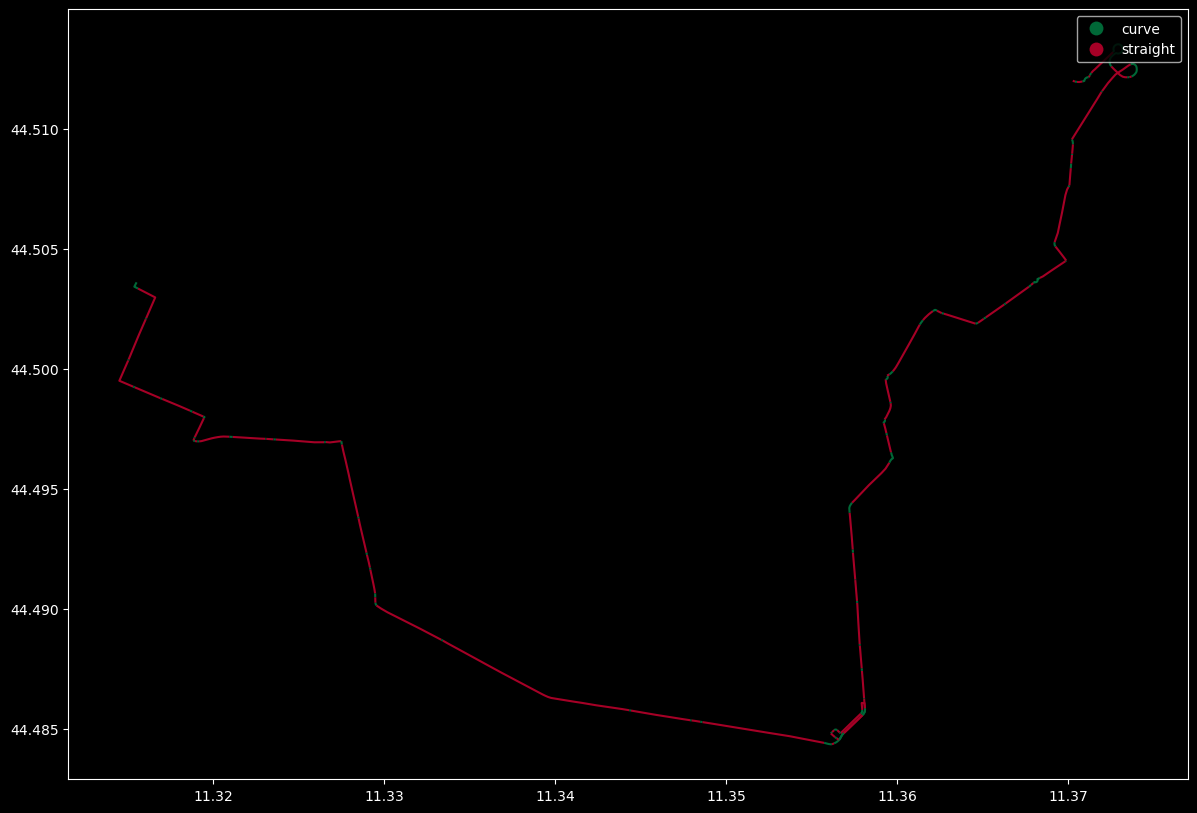

In [12]:
dist_treshold = 10
linestrings, curve_labels = split_linestring_by_curves(merged_route_polyline, dist_treshold)

def line_avg_dist(line: LineString):
    return sum([coord_distance_meters(cur, next) for cur, next in zip(line.coords[:-1], line.coords[1:])]) / (len(line.coords) - 1)

split_density_gdf = gpd.GeoDataFrame({
    'geometry': linestrings,
    'curve': ['curve' if x else 'straight' for x in curve_labels],
}, geometry='geometry', crs=graph_gdf_edges.crs)
split_density_gdf.plot('curve', categorical=True, legend=True, cmap='RdYlGn_r', figsize=(15,10))
display(split_density_gdf)

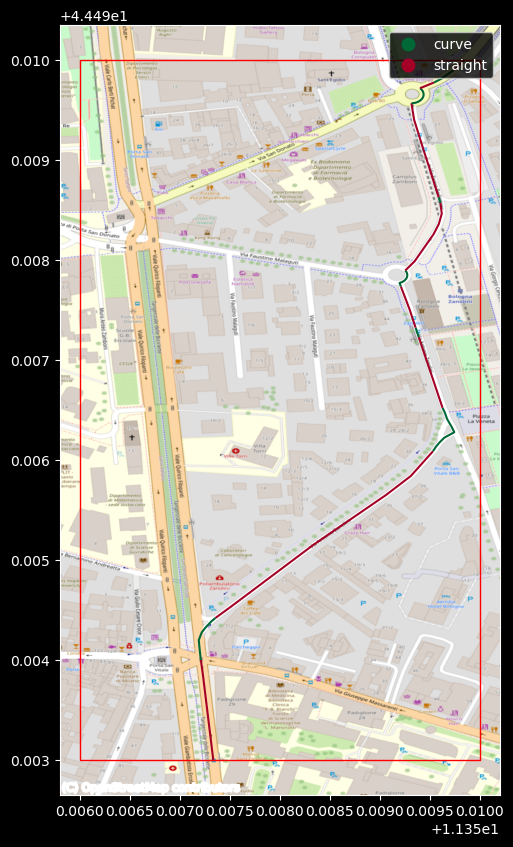

In [13]:
display_bounded_shapes([
    (split_density_gdf, {'column': 'curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'}),
], (11.356, 44.493), (11.36, 44.500), crs=split_density_gdf.crs, latLong=False);

In [14]:
def split_edges_gdf_by_density(gdf, treshold):
    split_global_geometry = gdf['geometry'].apply(lambda geom: split_linestring_by_curves(geom, treshold))
    tmp_graph_df_edges_copy = pd.DataFrame(gdf)
    tmp_graph_df_edges_copy[["groups", "labels"]] = pd.Series(split_global_geometry).apply(pd.Series)
    split_edges_gdf = gpd.GeoDataFrame(
        tmp_graph_df_edges_copy.explode(['groups', 'labels']).drop(["geometry"], axis=1)\
            .rename(columns={'groups': 'geometry'}),
        geometry='geometry',
        crs = gdf.crs,
    )
    split_edges_gdf['label'] = split_edges_gdf['labels'].apply(lambda x: 'curve' if x else 'straight')
    split_edges_gdf = split_edges_gdf.drop(['labels'], axis=1)
    return split_edges_gdf

In [15]:
split_edges_gdf = split_edges_gdf_by_density(graph_gdf_edges, dist_treshold)
split_edges_gdf.head()

osmid  \
u        v          key                                                      
31527579 31527604   0    [30573376, 238395972, 30573228, 238395982, 305...   
31527604 1800568909 0                      [30573376, 168873843, 30573606]   
                    0                      [30573376, 168873843, 30573606]   
                    0                      [30573376, 168873843, 30573606]   
         318021217  0                                [168873856, 28929804]   

                        bridge  oneway lanes  ref  \
u        v          key                             
31527579 31527604   0      yes    True     2   A1   
31527604 1800568909 0      yes    True     2   A1   
                    0      yes    True     2   A1   
                    0      yes    True     2   A1   
         318021217  0      yes    True   NaN  NaN   

                                                               name  \
u        v          key                                               
31527579 31527604   0    [Galleria Poggettone, Autostrada del Sole]   
31527604 1800568909 0                           Autostrada del Sole   
                    0                           Autostrada del Sole   
                    0                           Autostrada del Sole   
         318021217  0                                           NaN   

                               highway maxspeed reversed    length  ...  \
u        v          key                                             ...   
31527579 31527604   0         motorway      130    False  1652.764  ...   
31527604 1800568909 0         motorway      130    False   593.398  ...   
                    0         motorway      130    False   593.398  ...   
                    0         motorway      130    False   593.398  ...   
         318021217  0    motorway_link       40    False   253.435  ...   

                        grade_abs  speed_kph  travel_time  access  width  \
u        v          key                                                    
31527579 31527604   0       0.048      130.0         45.8     NaN    NaN   
31527604 1800568909 0       0.051      130.0         16.4     NaN    NaN   
                    0       0.051      130.0         16.4     NaN    NaN   
                    0       0.051      130.0         16.4     NaN    NaN   
         318021217  0       0.201       40.0         22.8     NaN    NaN   

                        junction service area  \
u        v          key                         
31527579 31527604   0        NaN     NaN  NaN   
31527604 1800568909 0        NaN     NaN  NaN   
                    0        NaN     NaN  NaN   
                    0        NaN     NaN  NaN   
         318021217  0        NaN     NaN  NaN   

                                                                  geometry  \
u        v          key                                                      
31527579 31527604   0    LINESTRING (11.22058 44.10132, 11.22037 44.101...   
31527604 1800568909 0    LINESTRING (11.23087 44.11357, 11.23103 44.114...   
                    0    LINESTRING (11.23146 44.11771, 11.23145 44.11774)   
                    0    LINESTRING (11.23145 44.11774, 11.23137 44.118...   
         318021217  0    LINESTRING (11.23087 44.11357, 11.23110 44.114...   

                            label  
u        v          key            
31527579 31527604   0    straight  
31527604 1800568909 0    straight  
                    0       curve  
                    0    straight  
         318021217  0    straight  

[5 rows x 22 columns]

In [16]:
split_edges_gdf.columns

Index(['osmid', 'bridge', 'oneway', 'lanes', 'ref', 'name', 'highway',
       'maxspeed', 'reversed', 'length', 'tunnel', 'grade', 'grade_abs',
       'speed_kph', 'travel_time', 'access', 'width', 'junction', 'service',
       'area', 'geometry', 'label'],
      dtype='object')

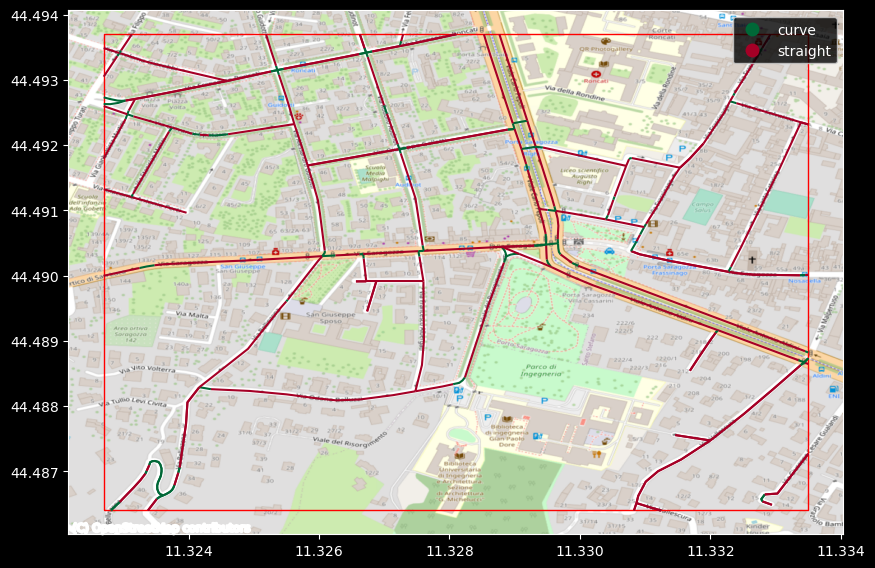

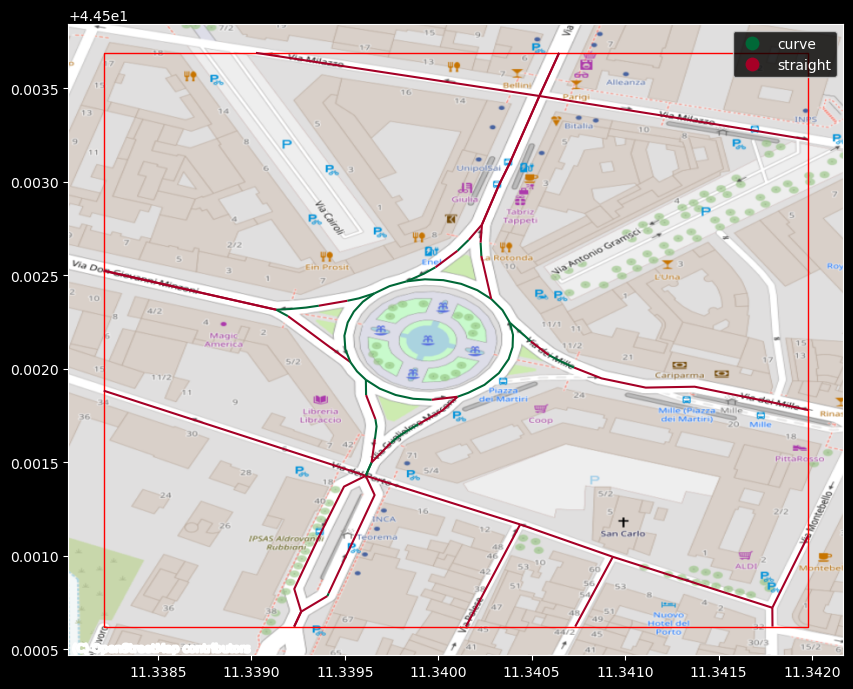

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


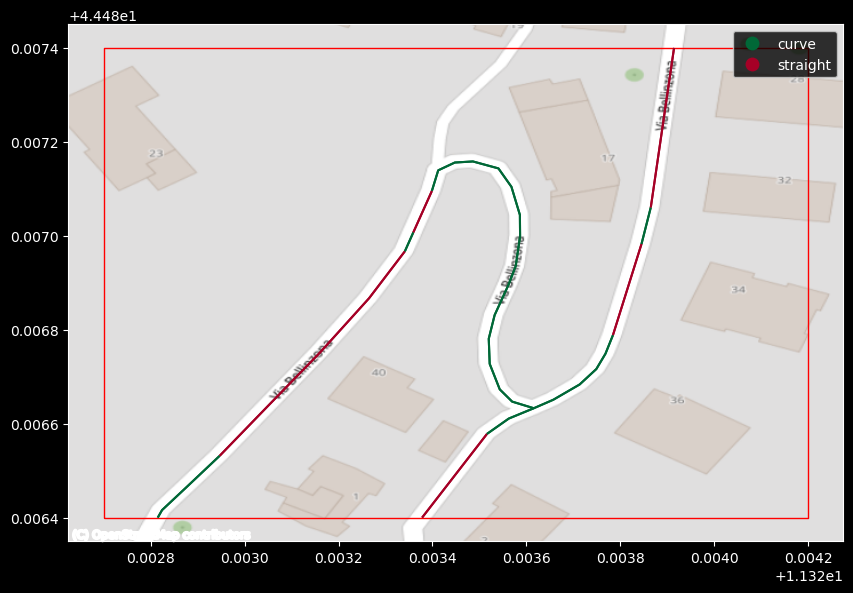

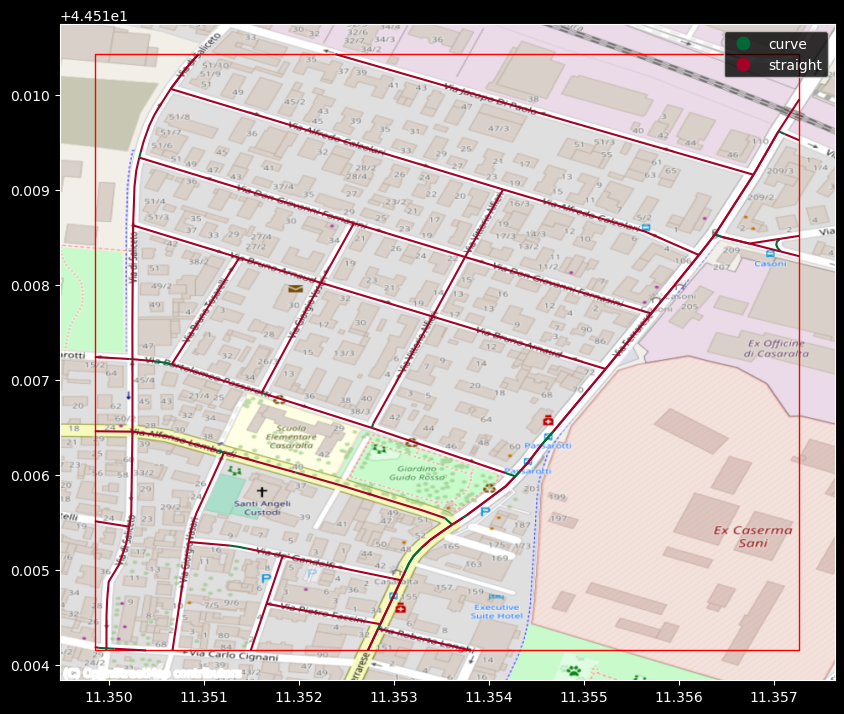

In [17]:
interesting_bound_set = [
    ( (44.4864, 11.3227), (44.4937, 11.3335) ),
    ( (44.50369, 11.33821), (44.50062, 11.34198) ),
    ( (44.4864, 11.3227), (44.4874, 11.3242) ),
    ( (44.51415,11.34985), (44.52043,11.35727) ),
]

for bounds in interesting_bound_set:
    display_bounded_shapes([
        (split_edges_gdf, {'column': 'label', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'})
    ], *bounds, latLong=True)

It can be noticed that the road in the last example is curved yet broken up by crossings, making the sampling here imperfect; that could be solved in a hypothethical path merging. Let's try with merged OSM ways:

In [18]:
graph_sep = load_graph(graph_area, allow_merge_different_osmids=False)
graph_gdf_nodes_sep, graph_gdf_edges_sep = ox.graph_to_gdfs(graph_sep)

Loading graph from D:\Documenti\Universita\tesim\resources\graph\Città Metropolitana di Bologna_nomerge.graphnx.pickle ...
Loaded in 1.39s!


In [19]:
from route2vel.loading import compress_edges_dataframe

ways_gdf = compress_edges_dataframe(graph_gdf_edges_sep.explode('osmid'), graph_gdf_nodes_sep, drop_complex_shapes=True)

[WARN] Merging geometries, match not found for node at (11.1203163, 44.7316545)
[WARN] Merging geometries, match not found for node at (11.1213497, 44.7392558)
[WARN] Merging geometries, match not found for node at (11.1484073, 44.5922267)
[WARN] Merging geometries, match not found for node at (11.057276, 44.5192511)
[WARN] Merging geometries, match not found for node at (11.0085545, 44.4301341)
[WARN] Merging geometries, match not found for node at (11.2544686, 44.7665803)
[WARN] Merging geometries, match not found for node at (11.0147094, 44.136613)
[WARN] Merging geometries, match not found for node at (11.1254103, 44.6282726)
Dropped 4 rows


In [20]:
split_ways_gdf = split_edges_gdf_by_density(ways_gdf, dist_treshold)

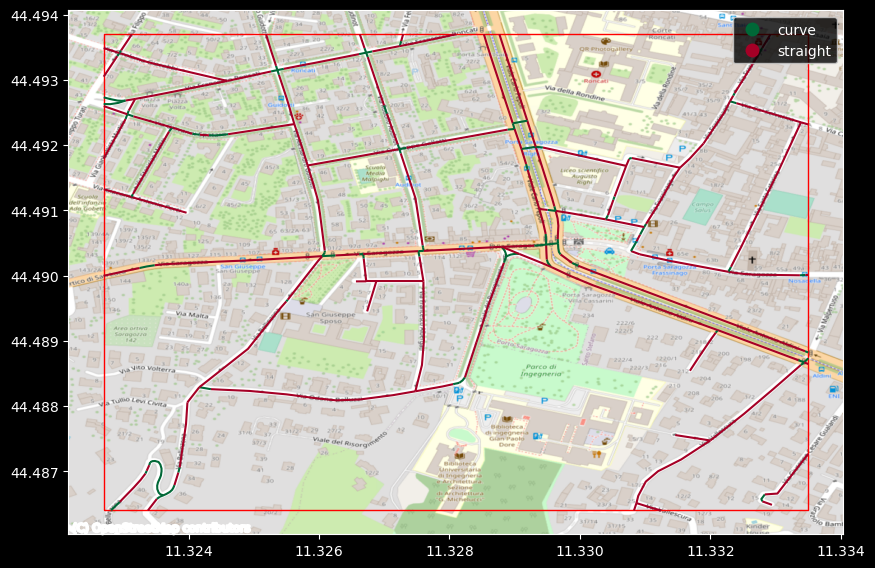

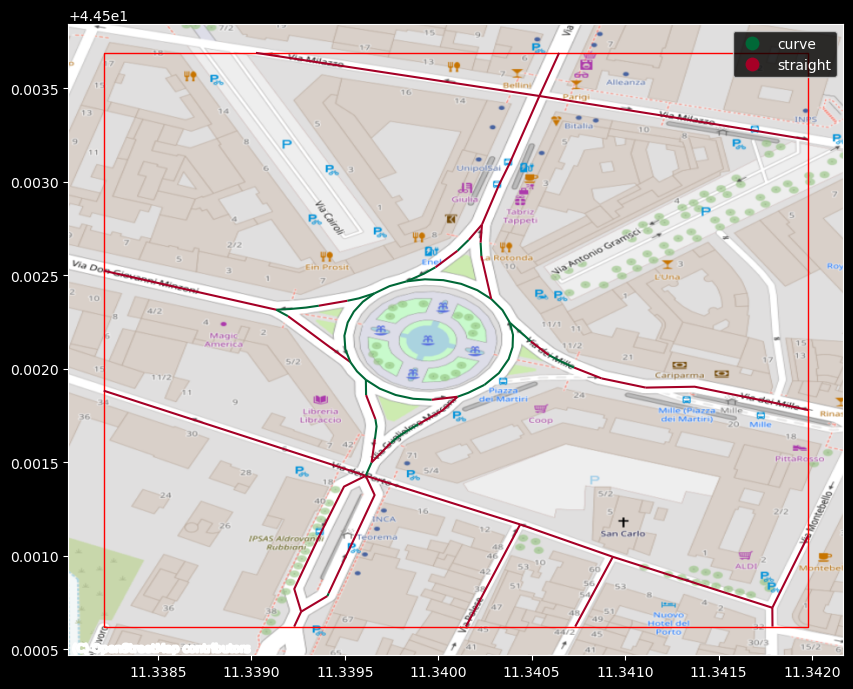

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


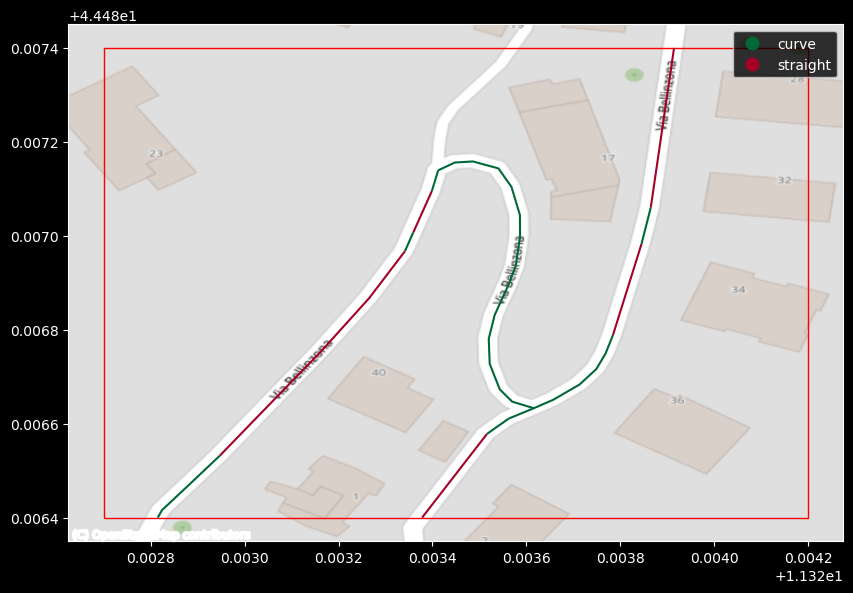

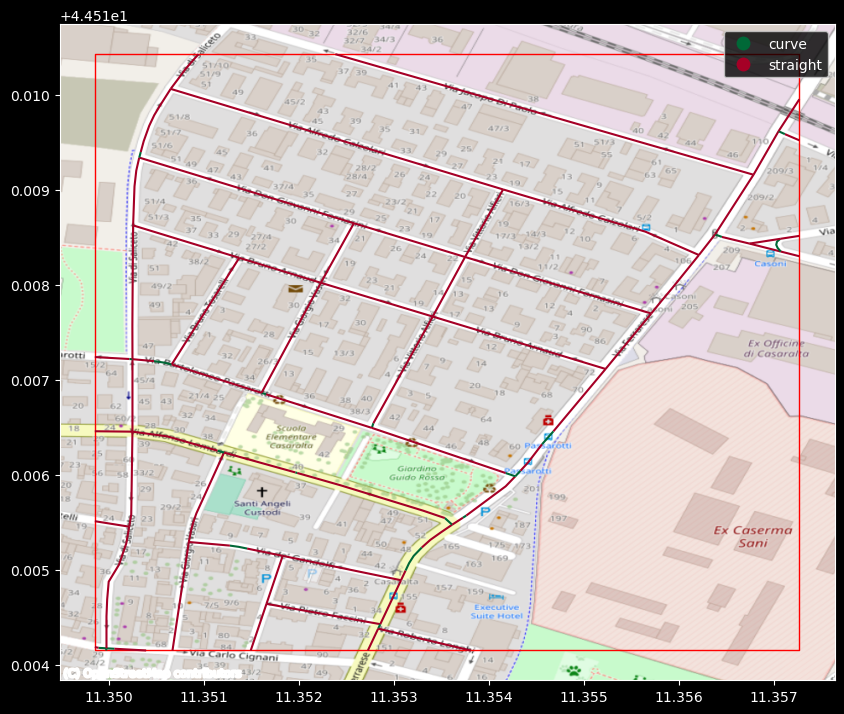

In [21]:
for bounds in interesting_bound_set:
    display_bounded_shapes([
        (split_ways_gdf.reset_index(), {'column': 'label', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'})
    ], *bounds, latLong=True)

Now let's try applying this to actual interpolation

In [22]:
from route2vel.interp import *

In [23]:
pts, pt_labels = get_point_in_linestrings_select_curves(linestrings, curve_labels, np.linspace(0, 1, num=10000), return_label=True)

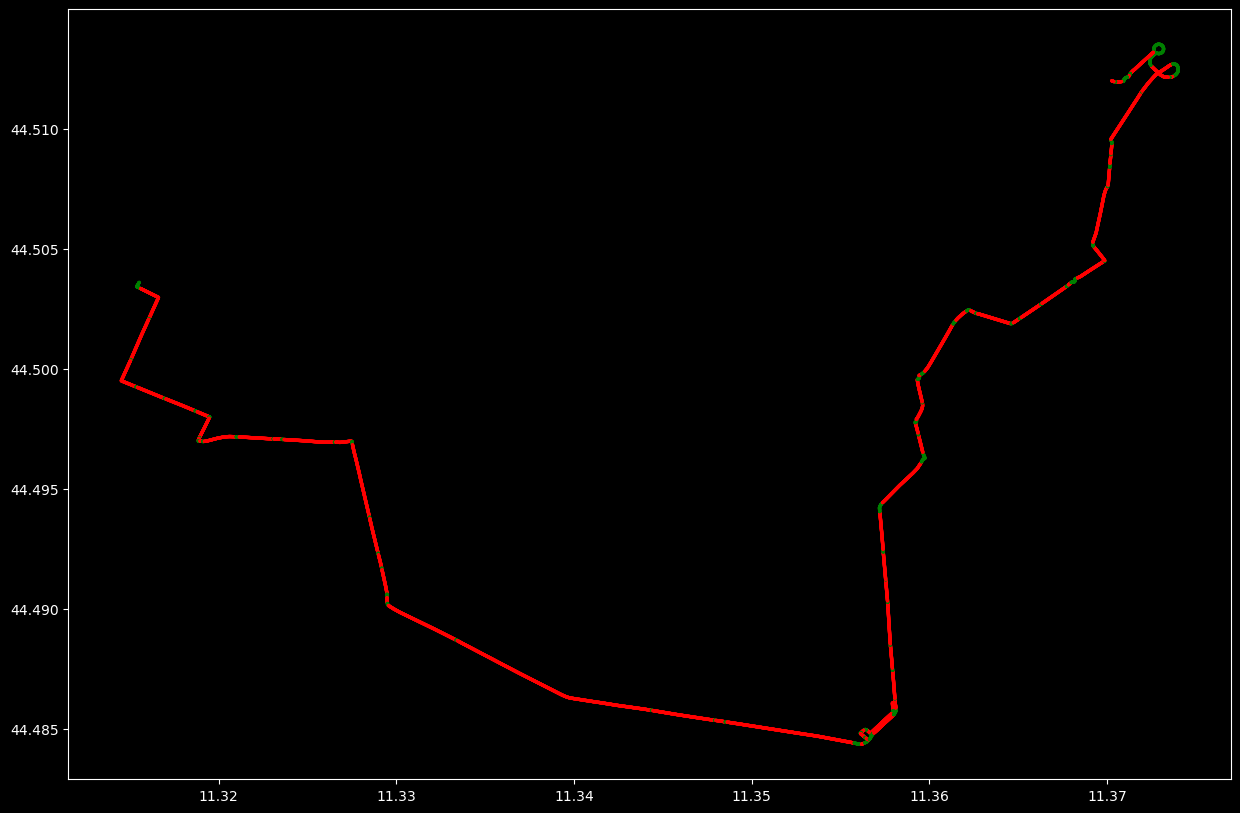

In [24]:
pts_x = pts.transpose()[0]
pts_y = pts.transpose()[1]

fig, ax = plt.subplots(figsize=(15, 10))
ax.scatter(pts_x, pts_y, s=2, color = ['g' if l else 'r' for l in pt_labels])
plt.show()

Zooming in:

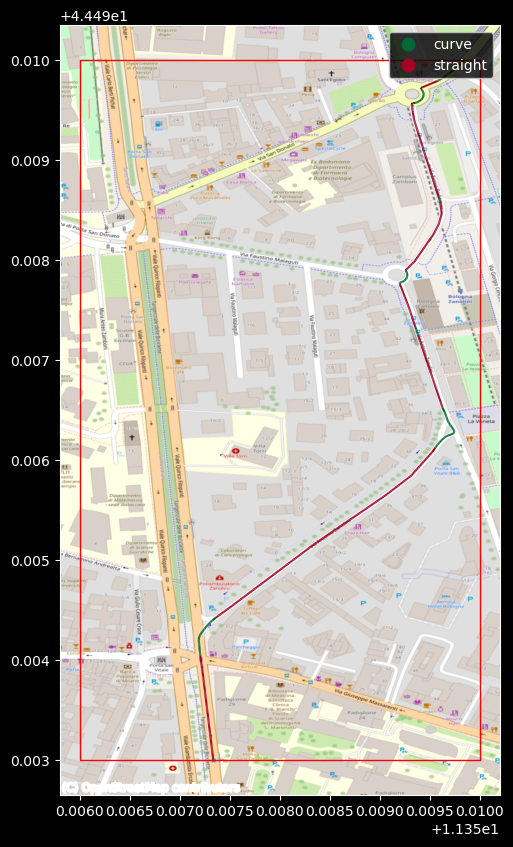

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


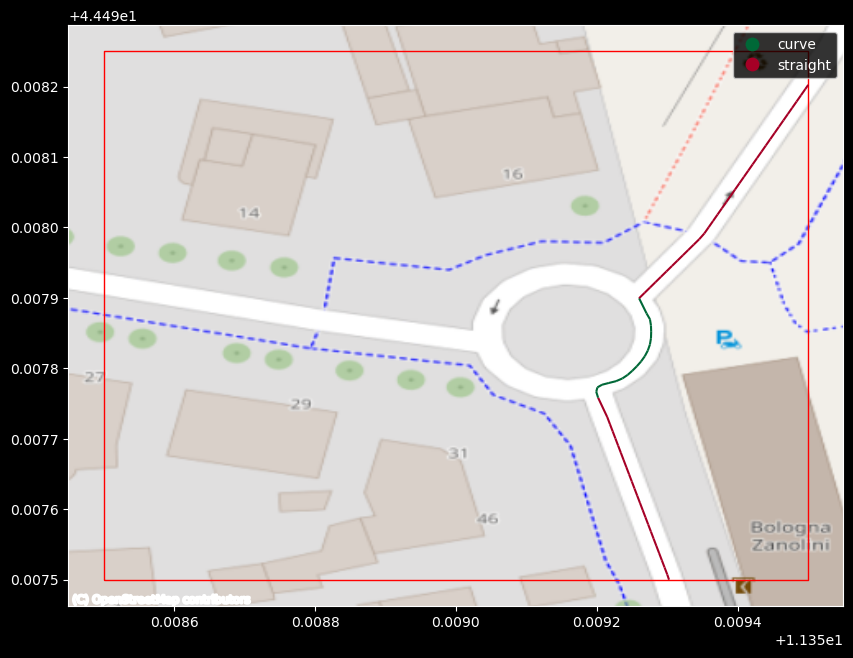

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


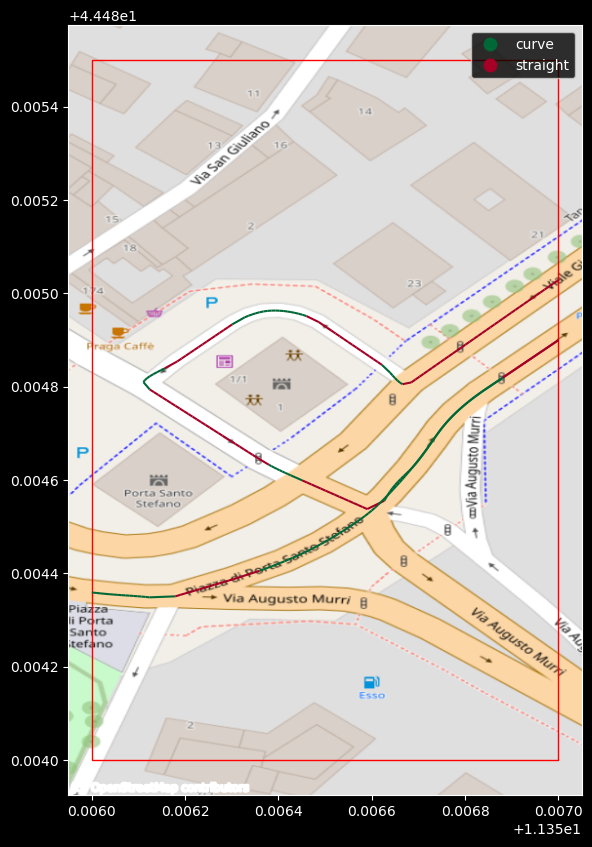

In [25]:
interesting_bound_set_route = [
    ((11.356, 44.493), (11.36, 44.500)),
    ((11.3585, 44.4975), (11.3595, 44.49825)),
    ((11.356, 44.484), (11.357, 44.4855)),
]

route_interp_gdf = gpd.GeoDataFrame({
    'geometry': [LineString([pt, next_pt]) for pt, next_pt in zip(pts[:-1], pts[1:])],
    'curve': ['curve' if l else 'straight' for l in pt_labels[:-1]],
}, geometry='geometry', crs=route_gdf.crs)

for bounds in interesting_bound_set_route:
    display_bounded_shapes([
        (route_interp_gdf, {'column': 'curve', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'}),
    ], *bounds, crs=route_gdf.crs, latLong=False);

For demonstration purposes, let's apply this to the whole graph:

In [53]:
global_interp = get_point_in_linestrings_select_curves(
        split_edges_gdf.geometry.to_list(), split_edges_gdf.label.to_list(), np.linspace(0, 1, num=100*len(graph_gdf_edges)), 
        continuous_lines=False,
    )

In [55]:
split_interp_gdf = gpd.GeoDataFrame({
    'geometry': [Point(x) for x in global_interp],
    # 'curve': ['curve' if l else 'straight' for l in pt_labels[:-1]],
}, geometry='geometry', crs=route_gdf.crs)

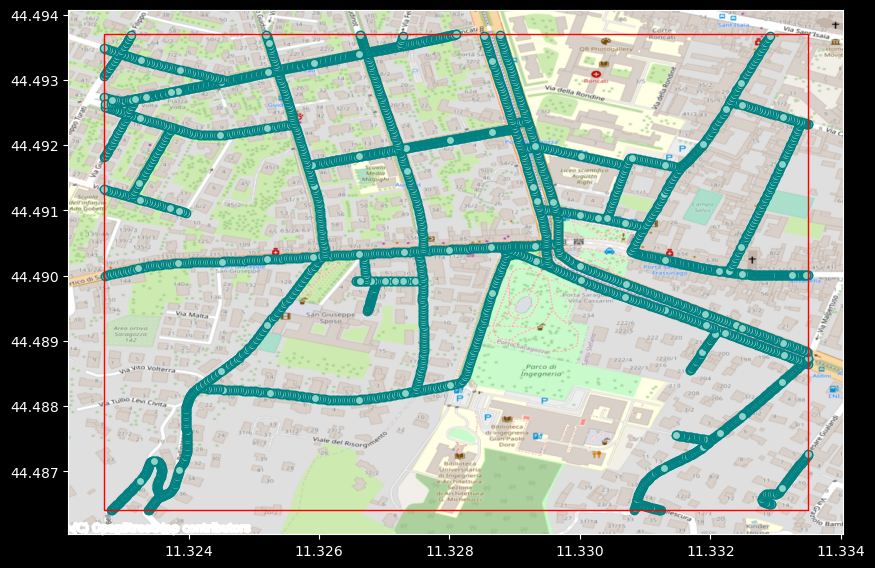

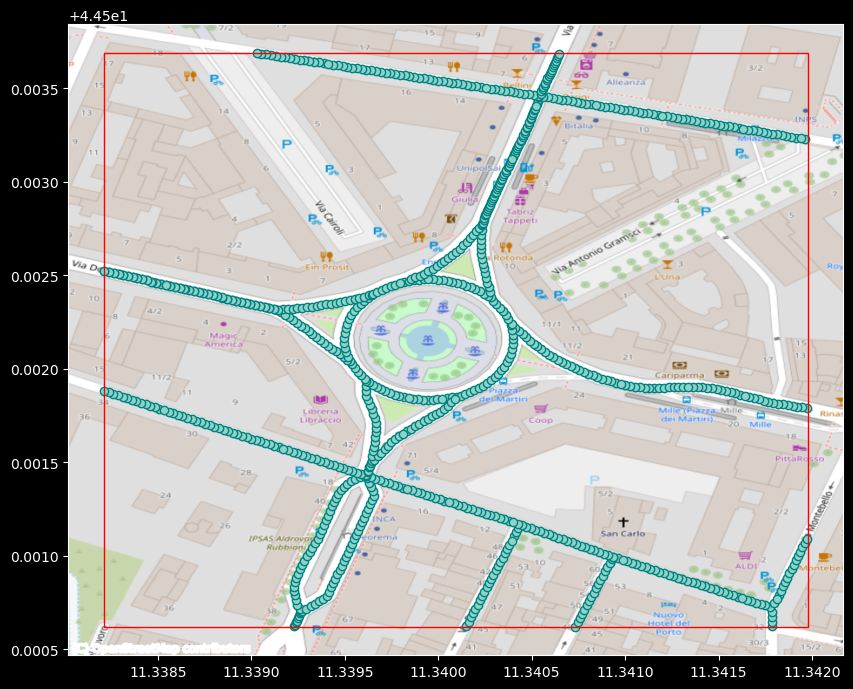

c:\Users\fillo\anaconda3\envs\ox\Lib\site-packages\contextily\tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


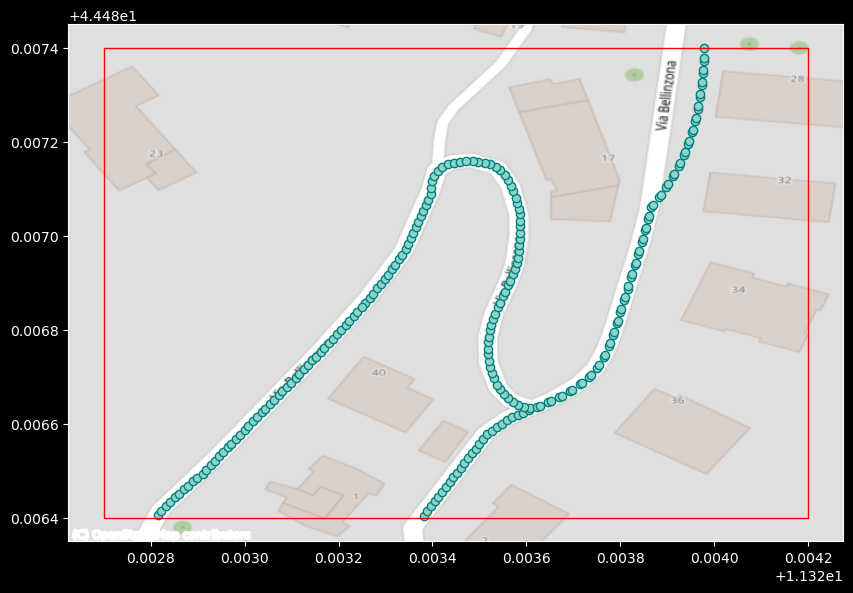

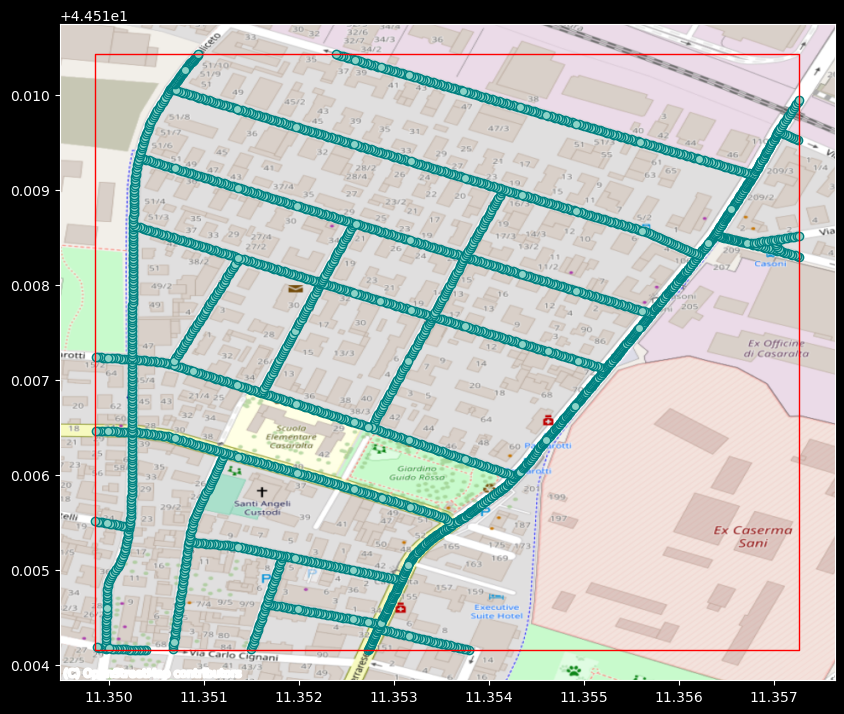

In [56]:
for bounds in interesting_bound_set:
    display_bounded_shapes([
        # (split_interp_gdf.reset_index(), {'column': 'label', 'categorical':True, 'legend':True, 'cmap':'RdYlGn_r'})
        (split_interp_gdf.reset_index(), {'aspect': 1})
    ], *bounds, latLong=True)